# Dependencies

I am running this notebook on ubuntu 18 and python 3.6 

The version of PyTorch used here is 1.0.0



In [65]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.simplefilter(action='ignore', category=FutureWarning)
from io import open
from collections import OrderedDict
import unicodedata

import pickle
import random
import numpy as np
import pandas as pd
import time
import re
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.autograd import Variable
from torch.distributions import Categorical
from torch import optim
import torch.nn.functional as F

print('you are using PyTorch version ',torch.__version__)

if torch.cuda.is_available():
    use_cuda = True
    print("you have", torch.cuda.device_count(), "GPUs")
    device = torch.device("cuda:0")
    print(device)
else:
    use_cuda = False
    print('no GPUs detected')
    device = torch.device("cpu")

%load_ext autoreload
%autoreload 2
%matplotlib inline

you are using PyTorch version  1.0.0
you have 2 GPUs
cuda:0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Lets load the data

if you have the data in a excel (xlsx) format, then save it to csv with ` , ` as the field delimiter and ` " ` as the text delimiter. It probably will not become an issue unless there are more than tens of thousands of rows in the excel file. At some point excel will fail to be a good storage option for large files and we will have to move onto something else, for tens for thousands, csv is an option. For millions, we will have to talk more. See the example below for excel and then csv. here is how you load the csv. 

In [66]:
df = pd.read_csv('saved/Sentiment_Raw.csv', index_col = 0)
num_rows, num_cols = df.shape
print("number of data points:",num_rows)
df.head()

number of data points: 8053


,v1,name,Sentiment,sent,date
Date,,,,,
02feb2000,303,MR. PRELL.,-1.0,Some buyers have moderated the immediate cash-...,20000202
02feb2000,965,MR. MCTEER.,-1.0,Both home building and commercial construction...,20000202
02feb2000,2285,MR. JORDAN.,-1.5,But this says to me that the market is not bui...,20000202
02feb2000,2014,CHAIRMAN GREENSPAN.,2.0,We are not accustomed to seeing motor vehicle ...,20000202
02feb2000,1056,MR. BOEHNE.,-0.5,The Labor Relations Committee of the Pennsylva...,20000202


# How I organized the data

I have designed the training protocol to read from a python list of lists. 
Each data point is a itself a list, if the first element is used as a class, it is important there is only one string for each class otherwise different strings will be considered different classes.

Below you can see that I have filtered the data by limiting only to strings below 100 words long. The final model can still handle any length sequence but will be trained on sentences lower than the threshold you set. In general, models learn better when tasks start off simple

In [67]:
# column index 2 is the label that comes as a flaot

lab_col_idx = 2
text_col_idx = 3
lab_type = float

df_list = df.values.tolist()

data_list = [[pair[lab_col_idx],pair[text_col_idx]] for pair in df_list if type(pair[lab_col_idx]) == lab_type \
             and type(pair[text_col_idx]) == str and len(pair[text_col_idx].split(' ')) < 200]



num_data_total = len(data_list)
print(num_data_total,data_list[0])

8053 [-1.0, 'Some buyers have moderated the immediate cash-flow hit by opting for adjustable rate loans, but this avenue will become less attractive under our monetary policy assumption.']


# split the dataset into training, validation and testing. 

Note: the random seed is initialized to split the same every time, but only on the first split, if you run this cell again you will have shuffled the data across groups

In [68]:
random.seed(0)
random.shuffle(data_list)

batch_size = 64
def myround(x, base=batch_size):
    return int(base * round(float(x)/base))

validation_proportion = 0.15
testing_proportion = 0.05

last_training_index = num_data_total - myround(num_data_total*(validation_proportion+testing_proportion))
last_validation_index = num_data_total - myround(num_data_total*(testing_proportion))

training_list = data_list[:last_training_index]
validation_list = data_list[last_training_index:last_validation_index]
test_list = data_list[last_validation_index:]

print(len(training_list),len(validation_list),len(test_list))

class_count = {}

for pair in validation_list:
    if pair[0] in class_count:
        class_count[pair[0]] += 1
    else:
        class_count[pair[0]] = 1
        
print(class_count)
majorityclassifier = max(class_count.values())/len(validation_list)
print("majority classifier", majorityclassifier )
print(training_list[0])

6453 1216 384
{-1.5: 304, -0.5: 113, 0.0: 279, 0.5: 74, 1.0: 120, -2.0: 41, 1.5: 130, -1.0: 138, 2.0: 17}
majority classifier 0.25
[0.0, 'We had a meeting at the Bank last week with representatives from the housing industry in the Twin Cities, including builders, brokers, and lenders, and most of these participants operate nationally.']


# Vocabulary

The model has a finite set of words aka sequence elements aka tokens that it recognizes. Here we have closen to make some words and some punctuation into tokens and allow for certain tokens that denote the end of a sentence, EOS, start of a sentence SOS, the presence of a word or symbol outside the vocabulary, UNK and a token used as padding when we need to force different length sequences to be the same length, PAD.

Each token has a corresponding vector, the default here is for the vectors to be 100 long, meaning each word is represented in 100 dimensional space and initialized randomly from a uniform distribution between 0.1 and -0.1

In [69]:
class Vocab:
    
    def __init__(self, word2index = None, class_str2idx = None):
        
        '''
        Use this class to incorpporate a folder of text documents into a vocabulary where the
        words in the text and the punctuation including ! ,  ? etc are converted to GloVe vectors
        and the words/tokens in the text documents not in glove are initialized as random vectors
        Store the string-token-to-index-token-mapping in the word2index and index2word dictionaries. 
        '''
        
        self.trimmed = False # gets changed to True first time Lang.trim(min_count) is called
        self.word2index = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3}
        self.word2count = {}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.next_empty_index = len(self.index2word) # Count <structure> tokens
        self.num_nonwordtokens = len(self.index2word) # nonwordtokenslike <UNK>
        self.PAD_token = 0
        self.SOS_token = 1
        self.EOS_token = 2
        self.UNK_token = 3
        self.embedding = []
        
        if word2index:
            self.vocab_size = len(word2index)
            self.word2index = word2index
            self.index2word = {v: k for k, v in word2index.items()}
            print('vocab_size', self.vocab_size)
            
        if class_str2idx:
            self.class_str2idx = class_str2idx
            self.idx2class_str = {v: k for k, v in class_str2idx.items()}
            self.num_classes = len(class_str2idx)
            print("num classes:", self.num_classes, "class2index mapping", class_str2idx)
            
    def class_index(self, data_list, class_index):

        class_set = set()

        for data_point in data_list:
            class_set.add(data_point[class_index])

        class_list = list(class_set)
        class_list.sort() # otherwise the mapping will be different with each creation
        idx2class_str = {i : class_list[i] for i in range(0, len(class_list)) }
        class_str2idx = {v: k for k, v in idx2class_str.items()}
        self.idx2class_str = idx2class_str
        self.class_str2idx = class_str2idx
        self.num_classes = len(class_str2idx)
        print("num classes:", self.num_classes, "class2index mapping", class_str2idx)
            
    def string_to_indexlist(self, sentence):
        sentence_as_indices = []
        sentence = self.normalize_string(sentence)
        for word in sentence.split(' '):
            if word in self.word2index:
                sentence_as_indices.append(self.word2index[word])
            else:
                sentence_as_indices.append(self.UNK_token)
        return sentence_as_indices + [self.EOS_token] 
            
    def unicode_to_ascii(self, s):
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn')
            
    def normalize_string(self, s):
        '''  this can be updated, since glove collapses certain punctuation like ' and `     '''
        s = self.unicode_to_ascii(s.strip())
        s = s.replace("'","")
        s = s.replace("`","")
        s = re.sub(r"([,.!?])", r" \1", s) # puts space between words and ,.!?
        s = re.sub(r"[^a-zA-Z0-9,.!?]+", r" ", s) #characts on in ^a-zA-Z0-9,.!? turn into a space 
        s = ' '.join(s.split())
        return s
        
    def index_word(self, word):
        ''' Updates word2index, index2word, word2count one string (word) at a time. 
        NOTE: this function does not normalize strings, for example if you want the 
        uppercase and lowercase of a word to be counted as the same word, you have to do that
        with another function'''
        
        if word not in self.word2index:
            self.word2index[word] =  self.next_empty_index
            self.index2word[self.next_empty_index] = word
            self.next_empty_index += 1
            self.word2count[word] = 1
        else:
            self.word2count[word] += 1

    def trim_dicts(self, min_count):
        '''
        Removes words from our 3 dictionaries that are below a certain count threshold (min_count)
        '''
        if self.trimmed: return
        self.trimmed = True
        
        keep_words = []
        
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words %s / %s = %.4f' % (
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3}
        self.word2count = {}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.next_empty_index = len(self.index2word) # Count <structure> tokens
        self.num_nonwordtokens = len(self.index2word)
        self.PAD_token = 0
        self.SOS_token = 1
        self.EOS_token = 2
        self.UNK_token = 3

        for word in keep_words:
            self.index_word(word)
            
    def index_sentence(self, sentence):
        '''
        Absorbs a sentence string into the token dictionary one word at a time by using ' ' as 
        a delimiter and using the index_word function which updates word2index, index2word, and
        word2count one string (word) at a time.
        '''
        for word in sentence.split(' '):
            self.index_word(word)
            
    def build_vocabulary(self, data_list, min_word_count = 5):
        
        '''
        data_list: python list of list, usually [label,input], if label or input are string, will be indexed 
        min_word_count: integer
        will digest a datalist into the word2index, index2word, and word2count dictionary fields of this class 
        '''
        
        if type(data_list) == list:
            
            for pair in data_list:
                for string in pair:
                    if type(string) == str:
                        self.index_sentence(self.normalize_string(string))
            
        else:
            print("not list")
            return
    
        print("trimming...")    
        self.trim_dicts(min_word_count)
        
        self.vocab_size = len(self.index2word)
        print('vocab_size', self.vocab_size)
    
    def initialize_embedding(self, embed_dim = 100):
        
        '''
        embed_dim:integer, number of dimensions you wish to represent words/tokens with
        '''
        
        # initialize our embedding matrix, each row is a token, each column is a dimension in the word vector
        # the number of tokens in index2word includes the <structure> tokens and all the words in our data that
        # are mentioned at least min_count times
        embedding = np.random.uniform(-0.1,0.1,(self.vocab_size, embed_dim)).astype(np.float32)
        self.embedding_numpy = embedding
        self.vector_dimensions = embed_dim
        print('finished embeddings: vocab_size', self.vocab_size, 'vector_dimensions',self.vector_dimensions)
    
    def combine_embedding(self, glove_vectors, gloveword2idx):
        ''' takes another embedding and where there is overlap, repalces your vector with theirs
            your dimensions much match'''
        num_vec_replaced = 0
        # now we fill in the word vectors portion of our embedding matrix
        for i in range(self.num_nonwordtokens,len(self.index2word)):
            # if a pre-initialized word vector exists for our token, we use it
            if self.index2word[i] in gloveword2idx:
                self.embedding_numpy[i,:] = glove_vectors[gloveword2idx[self.index2word[i]]]
                num_vec_replaced += 1
        print('number of vectors replaced',num_vec_replaced)
                
    def embedding_numpy_to_tensor(self,  train_embedding = True):
        '''turns the embedding matrix from numpy form to pytorch tensor'''
        self.EmbeddingMatrix = nn.Embedding(self.vocab_size, self.vector_dimensions)
        self.EmbeddingMatrix.weight = nn.Parameter(torch.from_numpy(self.embedding_numpy).float(), 
                                                   requires_grad=train_embedding)

# Building our tokens and word vectors

The steps below are to be performed in that order, the discription will explain why
1. instatiate the vocab class
2. index all the words in your trainingset that appear a certain number of times to use as your vocabulary
3. now that you have the number of words in your vocabular, initialize a matrix where each row is one work and each column is a dimension of that word, make that number of dimensions 100 if youwant to use incorporate 100 dim glove vectors into your vocabulary that there is a glove vector for
4. combine_embedding with previous trained toekn vectors
5. create EmbeddingMatrix field,  embedding_numpy_to_tensor method turns the embedding matrix from numpy form to pytorch tensor form, the train_embedding boolean denotes whether you want the gradient to modify the vectors as well

Note: be careful about the class_str2idx dictionary and that it matches the one the model was trained on previously when you load a trained model

In [70]:
vocab = Vocab()
vocab.class_index(data_list,0)
vocab.build_vocabulary(data_list, min_word_count = 4)
vocab.initialize_embedding(embed_dim = 100)
glove_vectors, gloveword2idx, gloveidx2word = pickle.load(open("saved/glove.p", "rb" ))
vocab.combine_embedding(glove_vectors, gloveword2idx)
vocab.embedding_numpy_to_tensor(train_embedding = True)

num classes: 9 class2index mapping {-2.0: 0, -1.5: 1, -1.0: 2, -0.5: 3, 0.0: 4, 0.5: 5, 1.0: 6, 1.5: 7, 2.0: 8}
trimming...
keep_words 3722 / 8933 = 0.4167
vocab_size 3726
finished embeddings: vocab_size 3726 vector_dimensions 100
number of vectors replaced 3255


# meaning of word vectors
similar word vectors cluster together and should both point in similar direction and close to one another (cosine similarity and euclidean distance)

In [71]:
def compare_words(string1,string2):
    wv1 = vocab.embedding_numpy[vocab.word2index[string1],:] 
    wv2 = vocab.embedding_numpy[vocab.word2index[string2],:] 
    euclidean_dist = np.linalg.norm(wv1-wv2)
    cos_sim = np.dot(wv1, wv2) / (np.sqrt(np.dot(wv2, wv2)) * np.sqrt(np.dot(wv1, wv1)))
    return euclidean_dist, cos_sim

print(compare_words("car","automobile"))
print(compare_words("car","food"))

(4.7657876, 0.6831942)
(7.228969, 0.34911004)


#  Multiclass Binary Cross Entropy

Since the labels are not distinct class like cat, car, tree etc, but rather they are ordered like A > B > C,
we will do what they outline here: https://stackoverflow.com/questions/38375401/neural-network-ordinal-classification-for-age
        use a sigmoid output and Binary corss entropy loss: BCEWithLogitsLoss https://pytorch.org/docs/stable/nn.html, the neural network will
                have 3 outputs, its sigmoid output, its logits and it's last layer encoding 

In [72]:
logits = torch.FloatTensor([[-10.0, 0.0, 10.0]])#torch.randn(3)
target = torch.FloatTensor([[0,1,1]])
one_hot = logits > 0
print(logits, target, one_hot.max(1))

sigmoid = nn.Sigmoid()
loss_function = nn.BCELoss()
loss = loss_function(sigmoid(logits), target)
print(loss)
loss_function = nn.BCEWithLogitsLoss()
loss = loss_function(logits, target)
print(loss)

tensor([[-10.,   0.,  10.]]) tensor([[0., 1., 1.]]) (tensor([1], dtype=torch.uint8), tensor([2]))
tensor(0.2311)
tensor(0.2311)


In [73]:
test_pair = training_list[1]
test_label = test_pair[0]
test_label_idx = 0 #vocab.class_str2idx[test_label]

test_batch_size = 1
target = torch.FloatTensor(test_batch_size,vocab.num_classes).random_(1) # samples from 0 to 1 , so all 1
#print(target[0].shape)
target1 = torch.FloatTensor(1,vocab.num_classes).random_(1)
target1.scatter_(1,torch.arange(test_label_idx).unsqueeze(0),1)
#print(target1.squeeze(0).shape)
target[0] = target1.squeeze(0)

print(test_pair)
print(target, target.shape, test_label, test_label_idx)

target_cpu = target.cpu().numpy().astype(int)
print(np.argmin(target_cpu, axis=1))


[-1.5, 'The slowdown was most apparent in housing and manufacturing.']
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.]]) torch.Size([1, 9]) -1.5 0
[0]


# The model training apparatus. 

A way to feed the model data, calculate the loss, backpropagate the loss to calculate the gradients and apply that gradient to update the model parameters.

In [74]:
class Trainer:
    
    def __init__(self, vocabClass):
        
        self.vocabClass = vocabClass
        self.vocab_size = len(vocabClass.word2index)

    def string_to_indexlist(self, sentence):
        sentence_as_indices = []
        sentence = self.vocabClass.normalize_string(sentence)
        for word in sentence.split(' '):
            if word in self.vocabClass.word2index:
                sentence_as_indices.append(self.vocabClass.word2index[word])
            else:
                sentence_as_indices.append(self.vocabClass.UNK_token)
        return sentence_as_indices + [self.vocabClass.EOS_token] 

    # Pad a with the PAD symbol
    def pad_seq(self,seq, max_length):
        seq += [self.vocabClass.PAD_token for i in range(max_length - len(seq))]
        return seq 

    def get_random_pairs(self,batch_size, list_of_list):
        
        input_seqs = []
        
        target = torch.FloatTensor(batch_size,self.vocabClass.num_classes).random_(1)

        for b in range(batch_size):
            pair = random.choice(list_of_list)
            label = pair[0]
            label_idx = vocab.class_str2idx[label]
            target_temp = torch.FloatTensor(1,self.vocabClass.num_classes).random_(1)
            target_temp.scatter_(1,torch.arange(label_idx).unsqueeze(0),1)
            target[b] = target_temp.squeeze(0)
            input_seqs.append(self.string_to_indexlist(pair[1]))
            
        input_lengths = [len(s) for s in input_seqs]
        input_padded = [self.pad_seq(s, max(input_lengths)) for s in input_seqs]
        input_var = torch.LongTensor(input_padded)

        return pair, target, input_var
    
    def as_minutes(self, s):
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

    def time_since(self, since, percent):
        now = time.time()
        s = now - since
        es = s / (percent)
        rs = es - s
        return '%s (- %s)' % (self.as_minutes(s), self.as_minutes(rs))
    
    def save_model(self, module, name):

        if use_cuda and torch.cuda.device_count() > 1:
            torch.save(module.state_dict(), "saved/"+name+"_parallel.pth")
        elif use_cuda:
            torch.save(module.state_dict(), "saved/"+name+"_gpu.pth")
        else: 
            torch.save(module.state_dict(), "saved/"+name+"_cpu.pth")

    def eval_dict(self, model, loss_function, list_of_list, batch_size):
        
        model.train(False)
        total_loss = 0
        total_correct = 0
        
        if len(list_of_list) % batch_size == 0:
            offset = 0
            for i in range(int(len(list_of_list) / batch_size)):
                
                input_seqs = []

                target = torch.FloatTensor(batch_size,self.vocabClass.num_classes).random_(1)
                
                for b in range(batch_size):
                    
                    pair = list_of_list[b + offset]
                    
                    label = pair[0]
                    label_idx = vocab.class_str2idx[label]
                    target_temp = torch.FloatTensor(1,self.vocabClass.num_classes).random_(1)
                    target_temp.scatter_(1,torch.arange(label_idx).unsqueeze(0),1)
                    target[b] = target_temp.squeeze(0) 
                    input_seqs.append(self.string_to_indexlist(pair[1]))
                    input_lengths = [len(s) for s in input_seqs]
                    input_padded = [self.pad_seq(s, max(input_lengths)) for s in input_seqs]
                    input_var = torch.LongTensor(input_padded)
                    
                if use_cuda:
                    target = target.cuda()
                    input_var = input_var.cuda()

                logits, encoding, attn_weights = model(input_var)
                loss = loss_function(logits, target)
                total_loss += loss.item()
    
                target_cpu = target.cpu().numpy().astype(int)
                logits_cpu = logits.detach().cpu().numpy()
                one_hot_cpu = logits_cpu > 0.0
                one_hot_cpu = one_hot_cpu.astype(int)
                #oh_v, one_hot_index = one_hot.max(1)
                #t_val, target_index = target_cpu.max(1)
                #print(target_cpu, np.argmin(target_cpu, axis=1))
                #print()
                #print(one_hot_cpu, np.argmin(one_hot_cpu, axis=1))
                #print() # one_hot, one_hot_index)
                total_correct += np.sum(np.argmin(target_cpu, axis=1) == np.argmin(one_hot_cpu, axis=1))
  
                offset += batch_size
        else:
            print(" length of data_list must be multiple of ", batch_size)
            return
            
        avg_loss = total_loss / int(len(list_of_list) / batch_size)
        accuracy = total_correct / int(len(list_of_list))
        return avg_loss, accuracy
        
    
    def training_loop(self, iterations, batch_size, module, data_list, learning_rate, 
                      gamma, patience, step_size, L2_reg, max_norm,majorityclassifier,name):
        
        '''  '''
        
        print("print every", int(step_size), "majority classifier", majorityclassifier)

        loss_function = nn.BCEWithLogitsLoss()

        optimizer = torch.optim.Adam(module.parameters(), lr=learning_rate, weight_decay=L2_reg)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',factor=gamma,patience=patience)
        
        current_loss = 0
        all_losses = []
        all_val_losses = []
        
        best_val_loss, val_accuracy = self.eval_dict(module, loss_function, validation_list, batch_size)

        print("initial val loss", best_val_loss, " initial val accuracy", val_accuracy)
        
        for iteration in range(1, iterations + 1):
            
            sample_pair, target, input_var = self.get_random_pairs(batch_size, data_list)
            
            if use_cuda:
                input_var = input_var.cuda()
                target = target.cuda()
            
            module.train(True)
            logits, encoding, attn_weights = module(input_var)
            #print(class_scores.shape, category_tensor.shape)
            loss = loss_function(logits, target)
            #print("TLOSS", loss)
            loss.backward()
            param_norm = torch.nn.utils.clip_grad_norm_(module.parameters(), max_norm , norm_type=2)
            optimizer.step()
            optimizer.zero_grad()
            
            current_loss += loss.item()
            
            if iteration % int(step_size) == 0:
                
                avg_val_loss, val_accuracy = self.eval_dict(module, loss_function, validation_list, batch_size)
                all_val_losses.append(avg_val_loss)
                all_losses.append(current_loss / step_size)
                print("train loss ", current_loss/step_size, "val loss", avg_val_loss, 
                      "val acc", val_accuracy , 'iter #', iteration)
                current_loss = 0
                
                scheduler.step(avg_val_loss)
                
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    print("new best, saving",name)
                    self.save_model(module, name)
                
        return all_losses, all_val_losses

In [75]:
trainer = Trainer(vocab)
batchsize = 1
pair, target, input_var = trainer.get_random_pairs(batchsize, data_list)
print(target.shape, input_var.shape)
print(target, input_var)

torch.Size([1, 9]) torch.Size([1, 18])
tensor([[1., 1., 0., 0., 0., 0., 0., 0., 0.]]) tensor([[  34,  344,  101,  154, 1803,  104,   52,   82,  524,   69, 2644, 2305,
          956,  304,    9,   72,   33,    2]])


# Model Architecture

I have modularized the components of the model and the training parallel. After each module you will see that I have fed a sample tensor into the model to show how it works.data paralellism splits along the zero-th dimension only, so the GRU instantiation parameters must set batch_first = True such that the input and output is of shape 

# The Encoder

## input_sequence_of_tokens - (batch_size, seq_len)

## encoder_output -  (batch size, sequence length, hidden size)

nn.DataParallel() will change the hidden output to (num_direc x num_layers x batch_size, 1, hidden_size)

In [76]:
class EncoderRNN(nn.Module):
    
    '''
    Input: There are two inputs to the Encoder:
        - sequence_of_vectors (batch_size, seq_len, vector_dims)
        - Initialized for you is the initial hidden state to feed to the GRU
          previous_hidden_state (number_of_directions*number_of_layers, batch_size, hidden_size)
        
    Outputs: There are two outputs to the GRU:
        - output(batch size, sequence length, hidden size),output is the last hidden states at each timestep
        - hidden(batch size, number_of_directions*number_of_layers, hidden size)
    
    '''
    
    def __init__(self, input_dim, hidden_size, num_layers, bidirectional = False, dropout = 0.2):
        
        super(EncoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.dropout = dropout # p=probability of being zeroed. Default: 0.5
        
        #batch_first = True means input is as (batch, seq, feature)
        self.gru = nn.GRU(input_dim, hidden_size, num_layers, batch_first = True,
                          dropout = dropout, bidirectional=bidirectional)
        
        if bidirectional:
            num_directions = 2
        else:
            num_directions = 1
        
        # make the initial hidden state learnable as well 
        initial_hidden = torch.zeros(self.num_layers*num_directions, 1, self.hidden_size)
        self.initial_hidden = nn.Parameter(initial_hidden, requires_grad=True)

    def forward(self, input_vectors):
        
        #print('inside input', input_vectors.shape)
        
        batch_size = input_vectors.size(0)
        
        hidden = self.initial_hidden.repeat(1, batch_size, 1)
        #print(' hidden.shape ',hidden.shape)
        self.gru.flatten_parameters()
        
        encoder_output, end_token_hidden = self.gru(input_vectors, hidden)
        
        #print('inside output',encoder_output.shape, end_token_hidden.shape)
        
        return encoder_output, end_token_hidden

The way that Recurrent Neural Networks work and the way the Data Paralellism works I found quite confusing, so I made it a point to allow some tinkering around with the model before using it to get a feel for the way it modifies the incoming and outgoing tensors

tensor : non-parallel    vs   parallel

output :(batchsize,sequencelength,hiddensize x numdirections)vs(batchsize,sequencelength,hiddensize x numdirections)

hidden : (num_directions x layers,batch_size,hidden_size) vs (num_direc x num_layers x batch_size, 1,hidden_size) 

Unidirectional non parallel

- deepest hidden state after last token: encoder_output[:,-1,:], same as end_token_hidden[-1,:,:]

Bidirectional non parallel

- deepest hidden state after last token in forward direction: encoder_output[:,-1,:hidden_size]
- deepest hidden state after last token in backward direction: encoder_output[:,0,hidden_size:]

- deepest hidden state after last token in forward direction: end_token_hidden[::2,:,:][-1]
- deepest hidden state after last token in backward direction: end_token_hidden[1::2,:,:][-1]

Bidirectional parallel

- deepest hidden state after last token in forward direction: encoder_output[:,-1,:hidden_size]
- deepest hidden state after last token in backward direction: encoder_output[:,0,hidden_size:]

- deepest hidden state after last token in forward direction: end_token_hidden[::2,0,:][1::2]
- deepest hidden state after last token in backward direction: end_token_hidden[1::2,0,:][1::2]

In [77]:
hidden_size = 4
num_layers = 2
vector_dimensions = 100

bidirectional = True
torch.manual_seed(0)

embedding = vocab.EmbeddingMatrix.cpu()

encoder = EncoderRNN(vector_dimensions, hidden_size, num_layers, bidirectional = bidirectional)

pair, target, input_var = trainer.get_random_pairs(batchsize, data_list)
    
input_vectors = embedding(input_var)

encoder_output, end_token_hidden = encoder(input_vectors)

print('output', encoder_output.shape, end_token_hidden.shape)

output torch.Size([1, 38, 8]) torch.Size([4, 1, 4])


# The Attention module

Attention does 2 things for us:

1. for long sequences where the signal from a particular hidden state might decay by the time it gets to the end of the sequence (forward or backward), it serves as a mechanism to copy that signal to the representation used for prediction

2. because it is trained along with the encoder and the attention weights serve as a probability distribution of importance over the input tokens, it lends interpretability to the model since it highlights important tokens from the input sequence

In Attention, the last hidden state after the last token is processed is compared to all the outputs in the sequence. The way that I deal with bidirectionality is to double the length of the hidden size

In [78]:
class Attention(nn.Module):
    
    '''
    input:
        encoder_output (batch size, sequence length, hidden size x num directions)
    output:
        attention_weights (batch_size, max_sequence_length)
        
    This attention uses the last hidden state of the last token (deepest, top cell, furthest from input) 
    concatenated with each of the last hidden states of the earlier tokens to generate an importance score
    then that score is run through a softmax to turn the scores into a probability distribution over 
    the input tokens that we call the attention weights
    '''
    
    def __init__(self, hidden_size, bidirectional = False):
        
        super(Attention, self).__init__()
        
        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        
        if self.bidirectional:
            input_size = hidden_size*4
        else:        
            input_size = hidden_size*2
        
        self.attention_neuralnet = nn.Sequential(
                       nn.Linear(input_size, hidden_size),
                       nn.PReLU(),
                       nn.Linear(hidden_size, hidden_size),
                       nn.Tanh(),
                       nn.Linear(hidden_size, 1)
                    )

    def forward(self, encoder_output):

        seq_len = encoder_output.size(1)
        this_batch_size = encoder_output.size(0)
        
        attn_energies = torch.zeros(this_batch_size, seq_len)#(batch_size,max_sequence_length)
        
        if next(self.parameters()).is_cuda:
            attn_energies = attn_energies.cuda()
        
        if self.bidirectional:
            encodingRNN = torch.cat((encoder_output[:,-1,:hidden_size], encoder_output[:,0,hidden_size:]), dim=1)
        else:
            encodingRNN = encoder_output[:,-1,:]
        
        for b in range(this_batch_size):

            for i in range(seq_len):
                
                attn_energies[b, i] = self.score(encodingRNN[b], encoder_output[b, i])

        attn_weights = F.softmax(attn_energies, dim = 1) #dim=1 softmax sequence foreach sample in batch 
        
        #transpose(0,1) transforms (seq_len,batch_size,hidden_size)=>(batch_size,seq_len,hidden_size)
        #unsqueeze(1) transforms (batch_size,seq_len) => (batch_size,1,seq_len)
        
        context_vector = attn_weights.unsqueeze(1).bmm(encoder_output) 
        
        return attn_weights, context_vector.squeeze(1)
    
    def score(self, encoding, encoder_output):
        concat = torch.cat((encoding, encoder_output))
        energy = self.attention_neuralnet(concat)
        return energy

In [79]:
# If attention is working correctly the sum across each sample should equal 1.0 approximately

attn = Attention(hidden_size, bidirectional)

attn_weights, context_vector = attn(encoder_output)
print(attn_weights)
print(torch.sum(attn_weights))

tensor([[0.0263, 0.0264, 0.0264, 0.0264, 0.0263, 0.0263, 0.0263, 0.0264, 0.0263,
         0.0263, 0.0264, 0.0264, 0.0263, 0.0263, 0.0263, 0.0263, 0.0263, 0.0264,
         0.0264, 0.0264, 0.0263, 0.0262, 0.0263, 0.0263, 0.0263, 0.0263, 0.0263,
         0.0263, 0.0264, 0.0264, 0.0263, 0.0262, 0.0263, 0.0264, 0.0264, 0.0263,
         0.0263, 0.0262]], grad_fn=<SoftmaxBackward>)
tensor(1.0000, grad_fn=<SumBackward0>)


# Fully Connected Layer

This layer combines the encoding and context vector to make a decision

In [80]:
class FullyConnected(nn.Module):
    
    def __init__(self, hidden_size, output_size, bidirectional, dropout = 0.2):
        
        super(FullyConnected, self).__init__()
        
        self.bidirectional = bidirectional
        
        if self.bidirectional:
            input_size = hidden_size*4
        else:        
            input_size = hidden_size*2
  
        self.fc1 = nn.Sequential(
                       nn.PReLU(),
                       nn.Linear(input_size, hidden_size),
                       nn.Dropout(p=dropout)
                       )
        
        self.fc2 = nn.Sequential(
                       nn.PReLU(),
                       nn.Linear(hidden_size, output_size)
                       )
        
    def forward(self, encoder_output, context_vector):

        if self.bidirectional:
            encoding = torch.cat((encoder_output[:,-1,:hidden_size], encoder_output[:,0,hidden_size:]), dim=1)
        else:
            encoding = encoder_output[:,-1,:]

        concat_encoding_context = torch.cat((encoding, context_vector), dim = 1)

        fc_encoding = self.fc1(concat_encoding_context)
        output = self.fc2(fc_encoding)

        return output, fc_encoding

In [81]:
num_outputs = 1
fc = FullyConnected(hidden_size, num_outputs, bidirectional)
 
class_scores, encoding = fc(encoder_output,context_vector)
class_scores

tensor([[0.0049]], grad_fn=<AddmmBackward>)

# The Model module is a combination of the above modules

In [82]:
class Model(nn.Module):
    
    def __init__(self, vocab, hidden_size, num_layers, bidirectional, num_ouputs):
        
        super(Model, self).__init__()
        
        self.vocab = vocab
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        self.embedding = vocab.EmbeddingMatrix
        self.encoder = EncoderRNN(vocab.vector_dimensions, hidden_size, num_layers, bidirectional)
        self.attention = Attention(hidden_size, bidirectional)
        self.fullyconnected = FullyConnected(hidden_size, num_ouputs, bidirectional)
    
    def forward(self, input_seqs):
        
        input_vectors = self.embedding(input_seqs)
        encoder_output, end_token_hidden = self.encoder(input_vectors)
        attn_weights, context_vector = self.attention(encoder_output) # output is used, not hidden, parrallel OK 
        class_scores, encoding = self.fullyconnected(encoder_output,context_vector)
        
        return class_scores, encoding, attn_weights

In [110]:
hidden_size = 1024
num_layers = 3
bidirectional = True

num_ouputs = vocab.num_classes #1
model = Model(vocab, hidden_size, num_layers, bidirectional, num_ouputs)

name = str(hidden_size)+'_'+str(num_layers)+'_bce_9class'

In [111]:
if use_cuda:
    
    # this is how you de-parallelize a model 
    state_dict = torch.load("saved/"+name+"_parallel.pth")
    new_state_dict = OrderedDict()

    for k, v in state_dict.items():
        paramname = k[7:] 
        new_state_dict[paramname] = v

    model.load_state_dict(new_state_dict)

    if torch.cuda.device_count() > 1:
        # this is how you re-parallelize a model
        model = nn.DataParallel(model)
        model = model.cuda()
    else:
        model = model.cuda()
else:
    model.load_state_dict(torch.load("saved/"+name+"_cpu.pth"))

In [112]:
loss_function = nn.BCEWithLogitsLoss()
avg_loss, accuracy = trainer.eval_dict(model,loss_function,validation_list,batch_size) #  validation_list test_list
print("avg_loss ", avg_loss, "accuracy ", accuracy) # 0.6325 # 0.67067

avg_loss  0.3037741333246231 accuracy  0.4087171052631579


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

In [113]:
iterations = 100 #change this to a much bigger number if you actually want to train 
print("iters per epoch", len(training_list)/batch_size, "num epoch",(batch_size*iterations)/len(training_list))
step_size=int(round(iterations/50))+1
print("step_size",step_size,"steps per epoch", len(training_list)/(step_size*batch_size))
L2_reg = 1e-6
max_norm = 1.0

iters per epoch 100.828125 num epoch 0.9917867658453432
step_size 3 steps per epoch 33.609375


In [114]:
learning_rate = 0.0001
gamma = 0.9
patience = 0.25*len(training_list)/(step_size*batch_size)

torch.cuda.empty_cache()

name = str(hidden_size)+'_'+str(num_layers)+'_bce_9class'

all_losses, all_val_losses = trainer.training_loop(iterations, batch_size, model, training_list,
                                                   learning_rate, gamma, patience, step_size, 
                                                   L2_reg, max_norm, majorityclassifier, name)

print every 3 majority classifier 0.25
initial val loss 0.3037741333246231  initial val accuracy 0.4087171052631579
train loss  0.3043465813000997 val loss 0.3139666248308985 val acc 0.3832236842105263 iter # 3
train loss  0.309486448764801 val loss 0.310829244161907 val acc 0.39555921052631576 iter # 6
train loss  0.2693330744902293 val loss 0.30525746706284973 val acc 0.4152960526315789 iter # 9
train loss  0.2551978975534439 val loss 0.3095235071684185 val acc 0.41776315789473684 iter # 12
train loss  0.28402019540468854 val loss 0.312634549642864 val acc 0.42269736842105265 iter # 15
train loss  0.3048541396856308 val loss 0.3105274564341495 val acc 0.4144736842105263 iter # 18
train loss  0.3015188972155253 val loss 0.3075967085988898 val acc 0.41694078947368424 iter # 21
train loss  0.2732160637776057 val loss 0.3071525402759251 val acc 0.4095394736842105 iter # 24
train loss  0.2658163209756215 val loss 0.30997897214011144 val acc 0.40131578947368424 iter # 27
train loss  0.2799

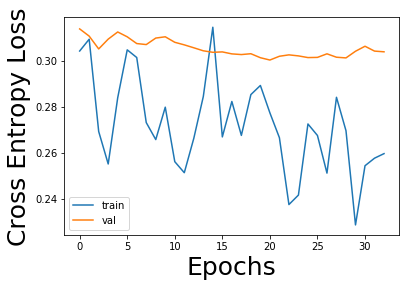

In [115]:
plt.figure()
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Cross Entropy Loss', fontsize=25)
plt.plot(all_losses, label='train')
plt.plot(all_val_losses, label='val')
plt.legend()
plt.show()

# How to load saved model parameters

Below we load a parallelized model and convert to cpu so that you can run the model on a computer without a GPU

In [116]:
hidden_size = 1024
num_layers = 3
bidirectional = True

num_ouputs = vocab.num_classes 
model = Model(vocab, hidden_size, num_layers, bidirectional, num_ouputs)

name = str(hidden_size)+'_'+str(num_layers)+'_bce_9class'

state_dict = torch.load("saved/"+name+"_parallel.pth")
new_state_dict = OrderedDict()

for k, v in state_dict.items():
    paramname = k[7:] 
    new_state_dict[paramname] = v
    
model.load_state_dict(new_state_dict)
model = model.cpu()
torch.save(model.state_dict(), "saved/"+name+"_cpu.pth")

In [117]:
def turn_attn_weight_into_color(weight, tmp_cmap):
    color_indx = int(255 * weight)
    r, g, b, alpha = [int(255 * tmp_cmap(color_indx)[i]) for i in range(4)]
    return(r, g, b)

def get_word_with_rgb(word, r, g, b):
    esc = "\x1b["
    txt_style = "2;"  # Text style ("1" is bold, "2" is not bold)
    toggle_bg = "48;2;"  # Switch to toggle background color (38;2; is foreground color)
    r = str(r)  # Red
    g = str(g)  # Green
    b = str(b)  # Blue
    ansi_code = esc + txt_style + toggle_bg + r + ";" + g + ";" + b + "m"
    return("%s%s" % (ansi_code, word))

def category_from_output(output,vocab):

    logits_cpu = output.detach().cpu().numpy()
    one_hot_cpu = logits_cpu > 0.0
    one_hot_cpu = one_hot_cpu.astype(int)
    index = np.argmin(one_hot_cpu, axis=1)
    
    return vocab.idx2class_str[int(index)], index

def predict_line(line, vocabClass, model):
        model.train(False)
        op_txt = ''
        my_cmap = plt.cm.get_cmap(name='Reds')
        tokens = re.split(' ', vocabClass.normalize_string(line))
        line_tensor = torch.LongTensor(vocabClass.string_to_indexlist(line)).unsqueeze(0)
        output, rep, attn_wts = model(line_tensor)
        #print(output)
        attn_weights = attn_wts.cpu().detach().numpy()[0][:-1]
        print("attention: ",list(attn_weights))
        #attn_weights = np.clip(attn_weights,0.0,2*np.mean(attn_weights))
        #attn_weights /= np.sum(attn_weights)

        guess, guess_i = category_from_output(output,vocabClass)
        for word_indx, word in enumerate(tokens):
            weight  = attn_weights[word_indx]
            r, g, b = turn_attn_weight_into_color(weight, my_cmap)
            op_txt += get_word_with_rgb(word, r, g, b) + ' '
        # Note that we have to explicitly set the normal background to plain ol' white
        print('prediction: ', guess)
        print(op_txt + '\n')
        
        return guess, output, attn_wts

In [118]:
index = 200
string = test_list[index][1]
print(string)
print()
print("label from list", test_list[index][0])
prediction, output, attention_weights = predict_line(string, vocab, model)

Im now expecting a period of declining employment, declining nonresidential construction, and flat-to-sluggish consumption.

label from list -2.0
attention:  [0.050044615, 0.050033353, 0.05003793, 0.050010644, 0.050015606, 0.050022285, 0.05001217, 0.049997672, 0.050008547, 0.050007973, 0.049999963, 0.050009977, 0.050007023, 0.049998056, 0.04999405, 0.049983848, 0.049974505, 0.04996221, 0.049965166]
prediction:  -1.5
Im now expecting a period of declining employment , declining nonresidential construction , and flat to sluggish consumption . 



In [119]:
# Just return an output given a line
def evaluate(line_tensor,model):
    model.train(False)
    output, rep, attn_wts = model(line_tensor)
    
    return output

# Keep track of correct guesses in a confusion matrix
n_categories = vocab.num_classes #1
print('n_categories',n_categories, vocab.idx2class_str, vocab.class_str2idx)
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 200

# Go through a bunch of examples and record which are correctly guessed

for i in range(n_confusion):
    pair, target, input_var = trainer.get_random_pairs(1, validation_list)
    #print(target)
    output = evaluate(input_var, model)
    #print(output)
    guess, guess_i = category_from_output(output,vocab)
    target_cpu = target.cpu().numpy().astype(int)
    category_i = int(np.argmin(target_cpu, axis=1))
    guess_i = guess_i 
    #print(category_i,guess_i)
    confusion[category_i][guess_i] += 1

                
    
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

n_categories 9 {0: -2.0, 1: -1.5, 2: -1.0, 3: -0.5, 4: 0.0, 5: 0.5, 6: 1.0, 7: 1.5, 8: 2.0} {-2.0: 0, -1.5: 1, -1.0: 2, -0.5: 3, 0.0: 4, 0.5: 5, 1.0: 6, 1.5: 7, 2.0: 8}


In [120]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label',fontsize=18) 
    plt.xlabel('Predicted label',fontsize=18)
    plt.tight_layout()

Normalized confusion matrix
[[0.         0.8888889  0.         0.         0.11111111 0.
  0.         0.         0.        ]
 [0.         0.74137932 0.10344828 0.0862069  0.03448276 0.
  0.03448276 0.         0.        ]
 [0.         0.23529412 0.11764706 0.29411766 0.17647059 0.
  0.05882353 0.11764706 0.        ]
 [0.         0.125      0.         0.5625     0.25       0.0625
  0.         0.         0.        ]
 [0.         0.08695652 0.02173913 0.19565217 0.65217394 0.04347826
  0.         0.         0.        ]
 [0.         0.14285715 0.14285715 0.         0.2857143  0.2857143
  0.14285715 0.         0.        ]
 [0.         0.31578946 0.05263158 0.2631579  0.         0.15789473
  0.05263158 0.15789473 0.        ]
 [0.         0.07407407 0.         0.11111111 0.03703704 0.03703704
  0.37037036 0.37037036 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.        ]]


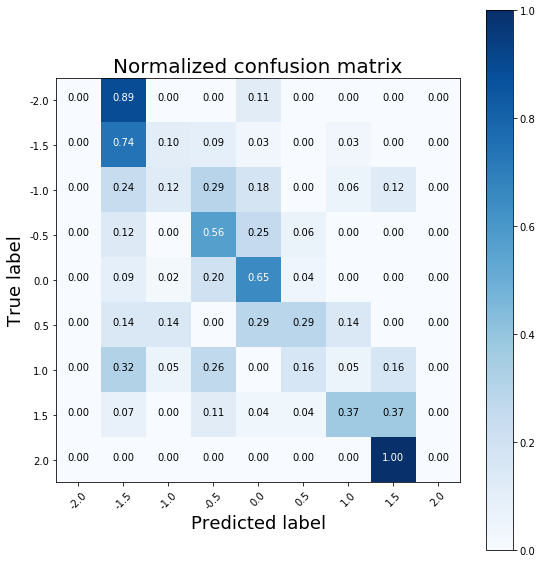

In [121]:
# Plot normalized confusion matrix
classlist = [k for k in sorted(vocab.class_str2idx, key=vocab.class_str2idx.get, reverse=False)]
classlist

plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion.numpy(), classes=classlist, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [43]:
class_str2idx = {'neutral': 2, 'slightly negative': 1, 'slightly positive': 3, 'very negative': 0, 'very positive': 4}
classlist = [k for k in sorted(class_str2idx, key=class_str2idx.get, reverse=False)]
classlist

['very negative',
 'slightly negative',
 'neutral',
 'slightly positive',
 'very positive']